In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-06-22 19:20:55.868865


In [2]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier as xgb
from xgboost import plot_importance
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [3]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
est_rmv = pd.read_csv('s3://bleeding-hearts/workingdata/est_rmv.csv')

In [4]:
#remove COI columns except for target: Child Opportunity Levels, overall COI, nationally-normed

#cols=list(est_rmv)
#coi_cols=cols[-8:]
#coi_cols.remove('Child Opportunity Levels, overall COI, nationally-normed')
#clean_cols = [i for i in cols if i not in coi_cols]
#est_rmv = est_rmv[clean_cols]
#est_rmv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Data columns (total 58 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Unnamed: 0                                                                                                                                                     18208 non-null  int64  
 1   EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force                                                                             18208 non-null  float64
 2   EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed                                         

In [4]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

In [5]:
cat_labels = list(set(est_rmv['Child Opportunity Levels, overall COI, nationally-normed']))

In [6]:
def assess_missing(df):
    missing_dict = {}
    cols=list(df)
    for c in cols:
        if len(df) - df[c].count() > 0:
             missing_dict[c] = ((len(df) - df[c].count())/len(df))*100
    return missing_dict

In [7]:
def viz_cb(y,lst):
    visualizer = ClassBalance(labels=lst)
    visualizer.fit(y)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [8]:
def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [9]:
def class_balance(df,target):
    print('Raw Value Counts:','\n',df[target].value_counts())
    X = df.loc[:, df.columns != target]
    y = df[target]
    #make a dataframe of value counts and a list of the values in the target
    df1 = y.value_counts().to_frame('count').reset_index(level=0).rename(columns={'index':'value'})
    label_lst = list(df1['value'])
    
    viz_cb(y,label_lst)

    #identify minimum value number and label name
    mi = df1['count'].min()
    name = df1.loc[df1['count'] == mi,'value'].iloc[0]
    print('min value is',name,'in values',label_lst)

    seed = 123
    # Downsample majority class
    
    #use min value number and label name to resample the dataframe
    df2 = pd.concat([resample(df[df[target]== i],
                            replace=False,
                            n_samples=mi,
                            random_state=seed) for i in label_lst if i != name]).append(df[df[target]== name])
    print('Resampled Value Counts:','\n',df2[target].value_counts())
    X = df2.loc[:, df.columns != target]
    y = df2[target]
    viz_cb(y,label_lst)
    return df2

In [10]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [11]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)
    
    expected  = y
    predicted = model.predict(X)
    
    

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [12]:
def conf_matrix(X,y,estimator,label_lst, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])


    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    #model.fit(X, y)
    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    )
    plt.tight_layout()
    plt.show()

In [13]:
def roc_auc(X,y,estimator,label_lst, **kwargs):
        y = LabelEncoder().fit_transform(y)
        model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])
        #Create the train and test data
        X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    # Instantiate the visualizer with the classification model

        visualizer = ROCAUC(model, classes=["Very High","High","Moderate","Low","Very Low"
])

        visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)        # Evaluate the model on the test data
        visualizer.show()                       # Finalize and show the figure

In [18]:
params = {
        # defining parameter range
          'C': [ 1, 10], 
          'gamma': [1, 0.1,],
          'kernel': ['rbf'] 
  }

models = [
    GridSearchCV(SVC(),params,
                scoring=('accuracy','balanced_accuracy','top_k_accuracy','f1_micro','f1_macro',
                          'f1_weighted','precision','recall','roc_auc','average_precision'),
                refit='f1_weighted',cv=5,return_train_score=True,n_jobs=6
                
                
                
                   

                )]

Raw Value Counts: 
 Very Low     4355
Low          4226
Moderate     3990
High         3328
Very High    2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


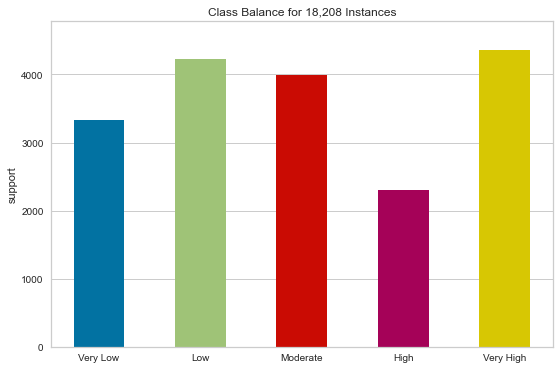

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 High         2309
Moderate     2309
Very High    2309
Very Low     2309
Low          2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


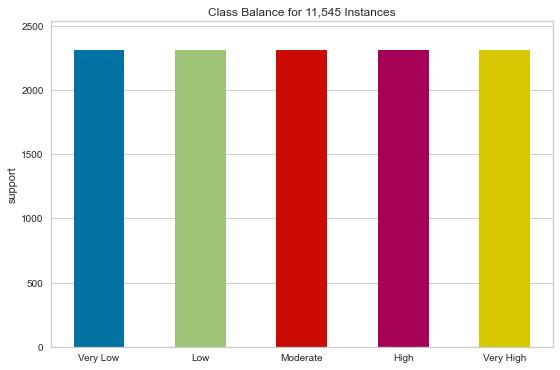

(9236, 64) (9236,)
(2309, 64) (2309,)
F1 SCORE GridSearchCV: 0.999393676916414


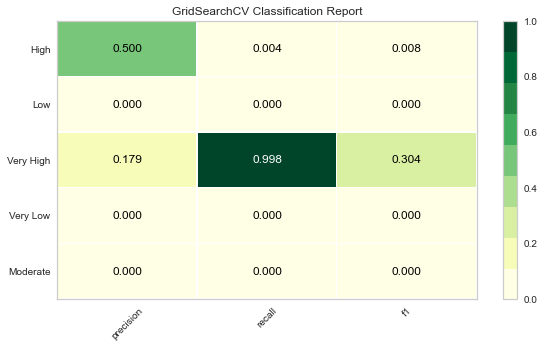

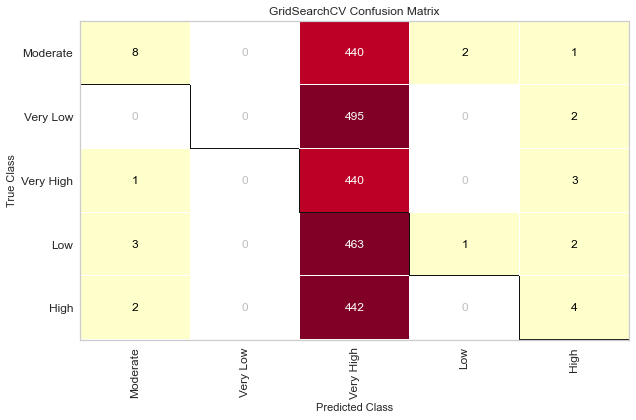

<Figure size 648x432 with 0 Axes>

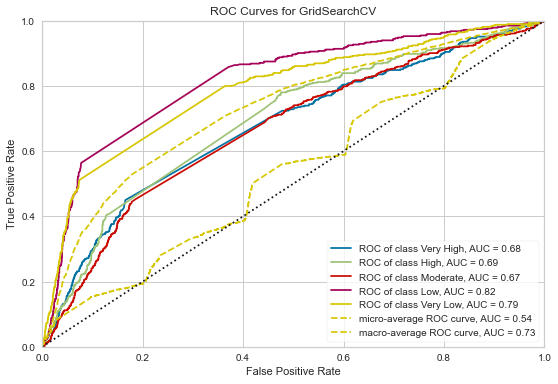

In [19]:
data = class_balance(est_rmv,'Child Opportunity Levels, overall COI, nationally-normed')
X = data.loc[:, data.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = data['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model, cat_labels)
        conf_matrix(X, y, model,cat_labels)
        roc_auc(X, y, model, cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)